In [1]:
from IPython.display import HTML
from IPython.display import display, Markdown


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Non-linear resonator dynamics simulation

The purpose of this notebook is to simulate ${\lambda}/{4}$ coplanar waveguide resonators, capacitively coupled to an open transmission line in a notch configuration.

<br>

<div>
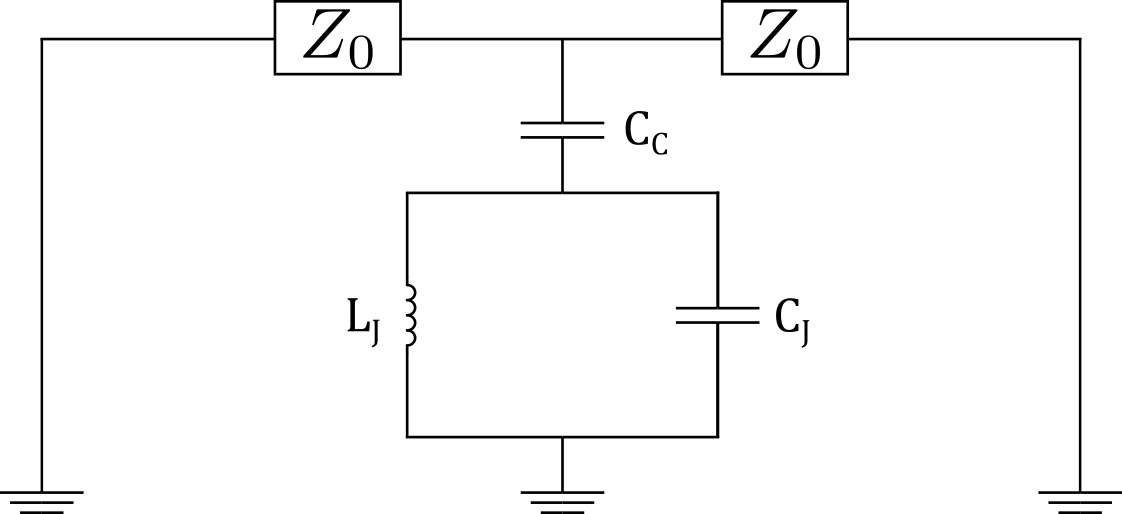
</div>

These resonators are designed and assumed to behave linearly, described as a harmonic LC oscillator to a generally satisfactory degree. 
We explore whether defects and loss channels, such as parasitic TLS, can give rise to non-linearities that are overlooked in ideal models.

<br>

<div>
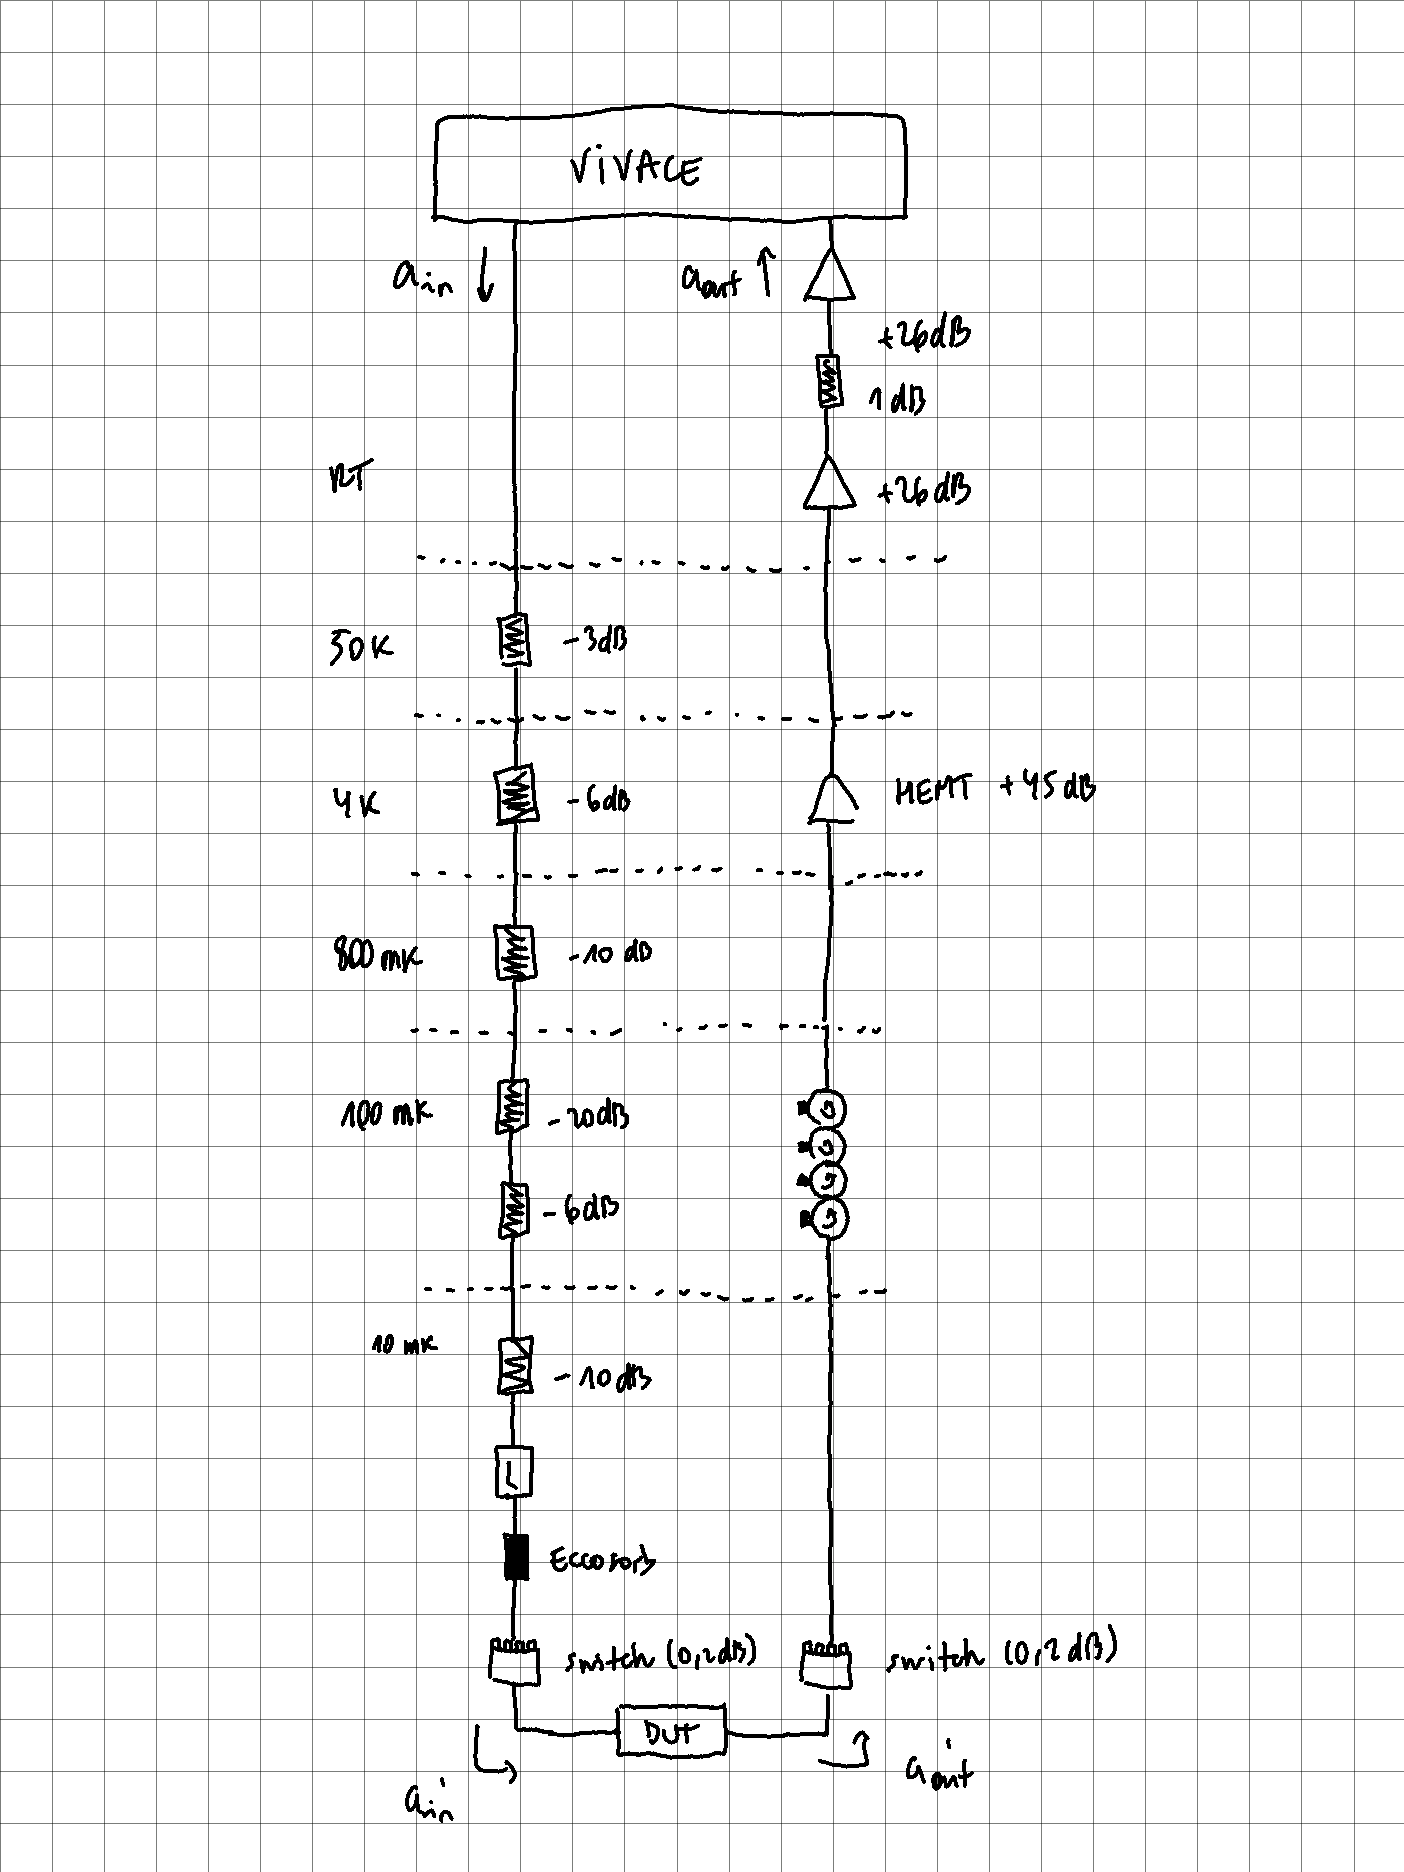
</div>

<br>
Our goal is to simulate the internal dynamics of the resonator ($a$).
Nevertheless, we only have direct access to information at the input and output ports of Vivace.
Therefore, to calculate the intra-cavity field we use input-output theory to obtain

$$ \dfrac{1}{\sqrt{G}} a_{out} = \dfrac{1}{\sqrt{\mathcal{A}}} a_{in} - \lambda a \quad \rightarrow \quad a = \dfrac{1}{\lambda} \left( \dfrac{a_{out}}{\sqrt{G}} - \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right), $$

where $G$ and $\mathcal{A}$ are the gain and attenuation of the output and input line respectively, and $\lambda$ represents the waveguide-resonator coupling rate.

The dynamics of the resonator are described by Heisenberg equation of motion 

$$ \dot{a} = -i \omega_r a - \kappa_0 a - \kappa_{TLS}(a) a + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}, $$

where $\omega_r$ indicates the resonant frequency, $\kappa_0$ the linear dissipation and $\kappa_{TLS}(a)$ the non-linear dissipation due to the TLS of the cavity.

The TLS non-linear dissipation is given by

$$ \kappa_{TLS}(a) = \dfrac{ \kappa_{TLS}}{\sqrt{1+ \left( a/a_c \right)^2}} = \kappa_{TLS} \left( 1 - \dfrac{1}{2} \left( \dfrac{a}{a_c} \right)^2 + \dfrac{3}{8} \left( \dfrac{a}{a_c} \right)^4 + \mathcal{O}(a^6) \right)  $$

For simplicity we rewrite the equation of motion as

$$ \dot{a} = -i \omega_r a - \kappa_1 a - \kappa_3 a^3 + \dfrac{\lambda}{\sqrt{\mathcal{A}}}a_{in}. $$

Eventually, we consider two known drive tones of the form

$$ a_{in} = F_0 \left( \cos({\omega_1}t) + \cos({\omega_2}t) \right) $$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import ipywidgets as widgets
from functools import partial
from scipy.integrate import ode
from scipy.signal import find_peaks
from ipywidgets import interactive

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Constants
π = np.pi

In [ ]:
# Functions
def eom_nonlinear(t, state, fr, κ1, κ3, λ, drive, ddrive):
    ωr = 2*π * fr
    state_norm = state / np.sqrt(gain)
    drive_norm = drive(t) / np.sqrt(att)
    ddrive_norm = ddrive(t) / np.sqrt(att)
    return  np.sqrt(gain) * (-1.0j*ωr*(state_norm-drive_norm) - κ1*(state_norm-drive_norm) - κ3*(state_norm-drive_norm)**3 + ddrive_norm + λ**2*drive_norm)


def eom_nonlinear_real(t, state_real, fr, κ1, κ3, λ, drive, ddrive):
    state_complex = state_real[::2] + 1j*state_real[1::2]
    ret_complex = eom_nonlinear(t, state_complex, fr, κ1, κ3, λ, drive, ddrive)
    tmp = np.zeros(len(ret_complex)*2)
    tmp[::2] = np.real(ret_complex)
    tmp[1::2] = np.imag(ret_complex)
    return tmp


def imp_drive(t, f1, f2, F0, φ1=0, φ2=0):
    ω1 = 2*π * f1
    ω2 = 2*π * f2
    return F0*(np.cos(ω1*t + φ1) + np.cos(ω2*t + φ2))


def imp_drive_derivative(t, f1, f2, F0):
    ω1 = 2*π * f1
    ω2 = 2*π * f2
    return -F0*(ω1*np.sin(ω1*t) + ω2*np.sin(ω2*t))


def nonlinear_simulation(f0, κ1, κ3, λ, f1, f2, F0):
        
    # Drive tones
    drive = partial(imp_drive, f1=f1, f2=f2, F0=F0)
    ddrive = partial(imp_drive_derivative, f1=f1, f2=f2, F0=F0)
    
    # Integrator
    o = ode( eom_nonlinear_real ).set_integrator('lsoda', atol=1e-12, rtol=1e-12)
    o.set_f_params(f0, κ1, κ3, λ, drive, ddrive)
    o.set_initial_value(y0, 0)
    
    # Time-domain solution
    y_all = np.zeros((len(t_all), len(y0)))
    for i,t in enumerate(t_all):
        o.integrate(t)
        y_all[i] = o.y
        
    
    # Merge the results onto the complex plane
    a_all = y_all[:,0] + 1.0j*y_all[:,1]
    
    # We save one oscillation once we reached the steady state
    a = a_all[-N-1:-1]
    t = t_all[-N-1:-1]
    
    # Fourier domain solution
    A = np.fft.fft(a) / len(a)
    f = np.fft.fftfreq(len(t), d=dt)


    # Indices of the IMPs
    max_ind_pos = find_peaks(x=np.abs(A[:1000]),
                             height=1e-9,
                            )
    max_ind_neg = find_peaks(x=np.abs(A[-1000:-900]),
                             height=1e-8,
                            )
    
    max_ind = np.append(max_ind_pos[0], len(A)-1000+max_ind_neg[0])
    print('Number of peaks: ', len(max_ind))
        
    # Drive indices
    ind_drives = np.array([954, 956, 19044, 19046])
    
    # Generated drive array in the frequency and time domain
    Ain = np.zeros_like(A, dtype=complex)
    Ain[ind_drives] = 0.5
    ain = np.fft.ifft(Ain)
    ain *= len(ain)
    
    return A, Ain, a_all, a, ain, f, t_all, t, drive, max_ind


def recon_nonlinear(A, Ain, a, ain, f, max_ind):
    
    # Angular frequency
    ω = 2*π * f
    
    # Create H-matrix
    col1 = (1.0j*ω*(A/np.sqrt(gain) - Ain/np.sqrt(att)))[max_ind]
    col2 = 1.0j*(A/np.sqrt(gain) - Ain/np.sqrt(att))[max_ind]
    col3 = (A/np.sqrt(gain) - Ain/np.sqrt(att))[max_ind]
    col4 = np.fft.fft((a/np.sqrt(gain) - ain/np.sqrt(att))**3 )[max_ind] / len(a)
    
    # Merge all columns
    H = np.vstack((col1, col2, col3, col4))
    
    # Making the matrix real instead of complex
    Hcos = np.real(H)
    Hsin = np.imag(H)
    H = np.hstack((Hcos, Hsin))
    
    # Normalize H for a more stable inversion
    Nm = np.diag(1. / np.max(np.abs(H), axis=1))
    H_norm = np.dot(Nm, H)  # normalized H-matrix
    
    # The drive vector, Q (from the Yasuda paper)
    Qcos = np.real(Ain/np.sqrt(att))[max_ind]
    Qsin = np.imag(Ain/np.sqrt(att))[max_ind]
    Q = np.hstack((Qcos, Qsin))
    
    # Solve system Q = H*p
    H_norm_inv = scipy.linalg.pinv(H_norm)
    p_norm = np.dot(Q, H_norm_inv)
    
    # Re-normalize p-values
    # Note: we have actually solved Q = H * Nm * Ninv * p
    # Thus we obtained Ninv*p and multiply by Nm to obtain p
    p = np.dot(Nm, p_norm)  # re-normalize parameter values
    
    # Forward calculation to check result, should be almost everything zero vector
    Q_fit = np.dot(p, H)
    
    # Scale parameters by drive force assuming known resonant frequency
    param_recon = p
    
    # Parameters reconstructed
    λ_recon = 1 / param_recon[0]
    f0_recon = λ_recon * param_recon[1] / (2*π)
    κ1_recon = λ_recon * param_recon[2]
    κ3_recon = λ_recon * param_recon[3]
    
    return λ_recon, f0_recon, κ1_recon, κ3_recon, Q_fit, Q

In [ ]:
# Gain and attenuation of the measurement lines
gain = 1
att = 1

# Drive parameters
λ = 1
F0 = 1
f1 = 0.954
f2 = 0.956
df = 0.001
fs = 20
N = int(round(fs/df))

# Integration parameters
T = 1. / df
T_relax = 5 * T
dt = 1. / fs
t_all = dt*(np.arange((T+T_relax)/dt) + 1) 

# Initial conditions
y0 = [0,0]

In [ ]:
# System parameters
f0 = 0.955
κ1 = 0.025
κ3 = κ1/100
Q_factor = 1/(2*κ1)

print('NON-LINEAR DAMPING OSCILLATOR')
print(f'f0 = {f0:.5f} Hz')
print(f'κ1 = {κ1:.5f}')
print(f'κ3 = {κ3:.5f}')
print(f'λ = {λ:.5f}')
print(f'Q_factor = {Q_factor:.0f}')


# Simulation
A, Ain, a_all, a, ain, f, t_all, t, drive, max_ind = nonlinear_simulation(f0, κ1, κ3, λ, f1, f2, F0)

In [ ]:
%matplotlib inline
verbose = False

# Check that the generated drive matches with the simulated drive
if verbose:
    # Drive array in time domain
    ain_all_simu = drive(t_all)
    ain_simu = ain_all_simu[-N-1:-1]
    Ain_simu = np.fft.fft(ain_simu) / len(ain_simu)
    
    # Drives in time and frequency domain
    fig, ax = plt.subplots(3, 1, figsize=[9, 6])
    ax[0].plot(t_all, np.abs(ain_all_simu))
    ax[1].plot(t, np.abs(ain_simu), label='Simulated')
    ax[1].plot(t, np.abs(ain), label='Generated')
    ax[2].semilogy(f, np.abs(Ain_simu), label='Simulated')
    ax[2].semilogy(f, np.abs(Ain), label='Generated')
    ax[0].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('$|a_{in}|$ [a.u.]')
    ax[2].set_xlabel('frequency [Hz]')
    ax[2].set_ylabel('$|\mathcal{F}(a_{in})|$ [a.u.]')
    ax[0].set_ylim(-0.1, 3)
    ax[2].set_ylim(1e-17, 100)
    ax[2].legend()


# Intra-cavity field in time and frequency domain
fig, ax = plt.subplots(3, 1, figsize=[9, 6])
ax[0].plot(t_all, np.abs(a_all) )
ax[1].plot(t, np.abs(a), label='output field')
ax[1].plot(t, np.abs(a/np.sqrt(gain)-ain/np.sqrt(att)), label='intra-cavity field')
ax[2].semilogy(f, np.abs(A), label='output field')
ax[2].semilogy(f, np.abs(A/np.sqrt(gain)-Ain/np.sqrt(att)), label='intra-cavity field')
ax[2].semilogy(f[max_ind], np.abs(A[max_ind]), '.', label='reconstruction')
ax[0].set_ylabel('$|a|$ [a.u.]')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('$|a|$ [a.u.]')
ax[2].set_xlabel('frequency [Hz]')
ax[2].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
ax[2].set_ylim(1e-14, 100)
ax[2].legend()    


# Reconstruction section
λ_recon, f0_recon, κ1_recon, κ3_recon, Q_fit, Q = recon_nonlinear(A, Ain, a, ain, f, max_ind)
Q_recon = 1 / (2*κ1_recon)

print(f'f0_recon = {f0_recon:.5f} Hz')
print(f'κ1_recon = {κ1_recon:.5f}')
print(f'κ3_recon = {κ3_recon:.5f}')
print(f'λ_recon = {λ_recon:.5f}')
print(f'Q_recon = {Q_recon:.0f}')
print('----------------------------------')

In [ ]:
# Plot only the region of interest

# create two subplots
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=False)

ax[0].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
fig.suptitle('frequency [Hz]', y=0, fontsize='medium')

# Plot same data on both axis
ax[0].semilogy(f, np.abs(A), label='output field')
ax[1].semilogy(f, np.abs(A), label='output field')
ax[0].semilogy(f[max_ind], np.abs(A[max_ind]), '.', label='reconstruction')
ax[1].semilogy(f[max_ind], np.abs(A[max_ind]), '.', label='reconstruction')

# limit each x axis to the chosen range
ax[0].set_xlim(-1, -0.92)
ax[1].set_xlim(0.92, 1)

# hide spines between both axes
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.tick_right()

d = .015 # how big to make the diagonal lines in axes coordinates

# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1-d,1+d), (-d,+d), **kwargs)
ax[0].plot((1-d,1+d), (1-d,1+d), **kwargs)

kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d,+d), (1-d,1+d), **kwargs)
ax[1].plot((-d,+d), (-d,+d), **kwargs)

# vary the distance between plots 
fig.subplots_adjust(wspace=0.2)
plt.show()

### Power Sweep

We want to check if our reconstruction algorithm works at different drive powers. 
For that we sweep over the parameter $F_0$.

In [ ]:
# Power Sweep

# System parameters
f0 = 0.955
κ1 = 0.025
κ3 = κ1/100
Q_factor = 1 / (2*κ1)

print('NON-LINEAR DAMPING OSCILLATOR')
print(f'f0 = {f0:.5f} Hz')
print(f'κ1 = {κ1:.5f}')
print(f'κ3 = {κ3:.5f}')
print(f'λ = {λ:.5f}')
print(f'Q_factor = {Q_factor:.0f}')

# "Power" values
F0_arr = np.logspace(0, 1, 21)

# Fit parameters
λ_recon_arr = np.zeros_like(F0_arr)
f0_recon_arr =  np.zeros_like(F0_arr)
κ1_recon_arr = np.zeros_like(F0_arr)
κ3_recon_arr = np.zeros_like(F0_arr)

A_arr = np.zeros((len(F0_arr), N), dtype=np.complex)
Ain_arr = np.zeros_like(A_arr)

# Power sweep
for F0_ind, F0_val in enumerate(F0_arr):
    
    # Simulation section
    A_arr[F0_ind], Ain_arr[F0_ind], a_all, a_arr, ain_arr, f_arr, t_all_arr, t_arr, drive_arr, max_ind_arr = nonlinear_simulation(f0, κ1, κ3, λ, f1, f2, F0_val)
    
    # Reconstruction section
    λ_recon_arr[F0_ind], f0_recon_arr[F0_ind], κ1_recon_arr[F0_ind], κ3_recon_arr[F0_ind], Q_fit, Q = recon_nonlinear(A_arr[F0_ind], Ain_arr[F0_ind], a_arr, ain_arr, f_arr, max_ind_arr)


In [ ]:
def F0_sweep(F0_ind):
    
    # create two subplots
    fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=False)
    
    fig.suptitle(f'$F_0$ = {F0_arr[F0_ind]:.1f}')
    ax[0].set_ylabel('$|\mathcal{F}(a)|$ [a.u.]')
    
    # Plot same data on both axis
    ax[0].semilogy(f, np.abs(A_arr[F0_ind]), label='output field')
    ax[1].semilogy(f, np.abs(A_arr[F0_ind]), label='output field')

    # limit each x axis to the chosen range
    ax[0].set_xlim(-1.1, -0.9)
    ax[1].set_xlim(0.8, 1)
    ax[0].set_ylim(1e-14, 1e2)
    ax[1].set_ylim(1e-14, 1e2)

    # hide spines between both axes
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].yaxis.tick_right()

    d = .015 # how big to make the diagonal lines in axes coordinates

    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
    ax[0].plot((1-d,1+d), (-d,+d), **kwargs)
    ax[0].plot((1-d,1+d), (1-d,1+d), **kwargs)

    kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
    ax[1].plot((-d,+d), (1-d,1+d), **kwargs)
    ax[1].plot((-d,+d), (-d,+d), **kwargs)

    # vary the distance between plots 
    fig.subplots_adjust(wspace=0.2)
    plt.show()


widgets.interact( F0_sweep, 
                  F0_ind=widgets.IntSlider(min=0, 
                                           max=len(F0_arr)-1, 
                                           step=1,
                                           description='F0_ind',
                                         )
                )

In [ ]:
# Parameters as a function of F0
fig, ax = plt.subplots(4)
ax[0].plot(F0_arr[1:], λ_recon_arr, '.-')
ax[1].plot(F0_arr[1:], f0_recon_arr, '.-')
ax[2].plot(F0_arr[1:], κ1_recon_arr, '.-')
ax[3].plot(F0_arr[1:], κ3_recon_arr, '.-')
ax[0].axhline(y=λ, linestyle='--', color='black')
ax[1].axhline(y=f0, linestyle='--', color='black')
ax[2].axhline(y=κ1, linestyle='--', color='black')
ax[3].axhline(y=κ3, linestyle='--', color='black')
ax[3].set_xlabel('$F_0$ [a.u.]')
ax[0].set_ylabel('$\lambda$ [a.u.]')
ax[1].set_ylabel('$f_0$ [Hz]')
ax[2].set_ylabel('$\kappa_1$ [a.u.]')
ax[3].set_ylabel('$\kappa_3$ [a.u.]')

In [ ]:
# Parameters as a function of F0
fig, ax = plt.subplots(4)
ax[0].plot(F0_arr[1:], λ_recon_arr, '.-')
ax[1].plot(F0_arr[1:], f0_recon_arr, '.-')
ax[2].plot(F0_arr[1:], κ1_recon_arr, '.-')
ax[3].plot(F0_arr[1:], κ3_recon_arr, '.-')
ax[0].axhline(y=λ, linestyle='--', color='black')
ax[1].axhline(y=f0, linestyle='--', color='black')
ax[2].axhline(y=κ1, linestyle='--', color='black')
ax[3].axhline(y=κ3, linestyle='--', color='black')
ax[3].set_xlabel('$F_0$ [a.u.]')
ax[0].set_ylabel('$\lambda$ [a.u.]')
ax[1].set_ylabel('$f_0$ [Hz]')
ax[2].set_ylabel('$\kappa_1$ [a.u.]')
ax[3].set_ylabel('$\kappa_3$ [a.u.]')